[<img src="https://user-images.githubusercontent.com/79705081/109483674-d3eea600-7a7f-11eb-9a25-58c50da4cde9.png">](http://edenlibrary.ai/)

## Instructions
To run any of Eden's notebooks, please check the guides on our [Wiki page](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki).<br>
There you will find instructions on how to deploy the notebooks on [your local system](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-Locally), on [Google Colab](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-on-GColab), or on [MyBinder](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-on-MyBinder), as well as other useful links, troubleshooting tips, and more.

**Note:** If you find any issues while executing the notebook, don't hesitate to open an issue on Github. We will try to reply as soon as possible.

## Background

In this notebook, **CLIP** model is going to be used to extract meaningful visual features from agricultural data. Then, on the top of those features, a linear model is trained to create the final classifier (Linear Probe). CLIP (Contrastive Language–Image Pre-training) is a model developed by OpenAI, designed to understand and generate content across both visual (images) and textual (language) modalities. It represents a significant step in the evolution of foundation models, particularly in the realm of multimodal AI.

### Defintions
**Foundation models** refer to a class of large-scale machine learning models that are trained on a broad range of data sources to acquire a wide set of capabilities. These models can be adapted or fine-tuned for various specific tasks and applications. On the other hand, 

**Multimodality** in machine learning refers to models that can understand, interpret, or generate data from multiple different modalities, such as text, images, audio, and video.

**Linear Probe** involves training a simple linear model, like logistic regression, on the features extracted from one of the layers of a pre-trained neural network. The objective is to see how well these features can be used for a specific task, such as classification.



#### Special Dependencies

In [1]:
!pip install -q git+https://github.com/openai/CLIP.git

#### Library Imports

In [1]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms

from pathlib import Path

import clip

import numpy as np
import os
import cv2
from tqdm import tqdm
from glob import glob

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

SEED = 2023

#### Auxiliar functions
Check the docstrings for more information.

In [2]:
def read_data(path_list, im_size=(224, 224)):
    """
    Given the list of paths where the images are stored <path_list>,
    and the size for image decimation <im_size>, it returns 2 Numpy Arrays
    with the images and labels.

        Parameters:
            path_list (List[String]): The list of paths to the images.
            im_size (Tuple): The height and width values.

        Returns:
            X (ndarray): Images
            y (ndarray): Labels
    """
    X = []
    y = []

    # Extract filenames of the datasets we ingest and create a label dictionary
    tag2idx = {tag.split(os.path.sep)[-1]: i for i, tag in enumerate(path_list)}

    for path in path_list:
        for im_file in tqdm(glob(path + "*/*")):  # Read all files in path
            try:
                # os.path.separator is OS agnostic (either '/' or '\'),[-2] to grab folder name
                label = im_file.split(os.path.sep)[-2]
                im = cv2.imread(im_file, cv2.IMREAD_COLOR)
                # By default OpenCV reads with BGR format, convert to RGB
                im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
                # Resize to appropriate dimensions
                im = cv2.resize(im, im_size, interpolation=cv2.INTER_AREA)
                X.append(im/255.0)
                y.append(tag2idx[label])  # Append the label name to y
            except Exception as e:
                # In case annotations or metadata are found
                print(e)

    X = np.array(X)  # Convert list to numpy array.
    y = np.array(y).astype(np.uint8)

    return X, y

### Important function
It extracts the visual features

In [3]:
def get_features(dataset, batch_size=32):
    """
    This function uses CLIP to extract the visual features from the images.
    """
    all_features = []
    all_labels = []

    with torch.no_grad():
            for images, labels in tqdm(DataLoader(dataset, batch_size=batch_size)):
                features = model.encode_image(images.to(device))

                all_features.append(features)
                all_labels.append(labels)

    return torch.cat(all_features).cpu().numpy(), \
            torch.cat(all_labels).cpu().numpy()

### Auxiliar Class

In [ ]:
class WeedIdentificationDataset(Dataset):
    def __init__(self, x, y, transforms=None):
        super(WeedIdentificationDataset, self).__init__()
        self.x = x
        self.y = y
        self.transforms = transforms

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        images = self.x[idx]
        labels = self.y[idx]

        if self.transforms:
            images = self.transforms(images)

        return images, labels

#### Experimental Constants

In [4]:
# Eden datasets we will work on
PATH_LIST = [
    "Black nightsade-Solanum nigrum-220519-Weed-zz",
    "Tomato-Solanum lycopersicum-240519-Healthy-zz"
]

IM_SIZE = (224, 224)

#### Loading images

In [22]:
i = 0
for path in PATH_LIST:
    # Define paths in an OS agnostic way.
    PATH_LIST[i] = str(
        Path(Path.cwd()).parents[0].joinpath("eden_library_datasets").joinpath(path)
    )
    i += 1
x, y = read_data(PATH_LIST, IM_SIZE)

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 105/124 [00:21<00:03,  4.78it/s]

OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'



 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 174/201 [00:57<00:08,  3.06it/s]

OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [01:05<00:00,  3.06it/s]


#### Setting CUDA configuration if available

In [6]:
# Using CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Data preprocessing
1. Train-test splitting
2. Tensors creation
3. Dataset creation from tensors with normalization

In [23]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size = 0.25, shuffle=True, stratify=y, random_state=SEED
)

In [24]:
x_train = torch.tensor(x_train, dtype=torch.float32).permute(0, 3, 1, 2)
x_test = torch.tensor(x_test, dtype=torch.float32).permute(0, 3, 1, 2)

In [25]:
naive_preprocess = transforms.Compose([
    transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073),
                         std=(0.26862954, 0.26130258, 0.27577711))
]
)

In [26]:
train = WeedIdentificationDataset(x_train, y_train, naive_preprocess)
test = WeedIdentificationDataset(x_test, y_test, naive_preprocess)

### Loading CLIP model

In [27]:
model, preprocess = clip.load("ViT-B/32", device)

### Phase 1: Feature Extraction

In [28]:
train_features, train_labels = get_features(train)
test_features, test_labels = get_features(test)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 41.36it/s]


### Phase 2: Linear Probe

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [30]:
# Perform logistic regression
classifier = LogisticRegression()
classifier.fit(train_features, train_labels)

LogisticRegression()

### Evaluation

In [34]:
predictions = classifier.predict(test_features)

In [35]:
accuracy_score(test_labels, predictions)

1.0

### Images represetation
We are using the t-SNE algorithm to project the original dimensions into a 2 or 3 dimensional space. **t-Distributed Stochastic Neighbor Embedding (t-SNE)** is a machine learning algorithm used mainly for the visualization of high-dimensional data. It's particularly useful in the fields of data science and machine learning for understanding complex datasets. t-SNE is a form of manifold learning. It works by capturing the local structure of the high-dimensional space and then revealing these structures in a lower-dimensional space, often revealing clusters or groupings in the data. The key feature of t-SNE is its ability to preserve local structures and relationships between points. Similar data points in the high-dimensional space will be close to each other in the low-dimensional space. The resulting visualization often shows distinct clusters, which can be extremely useful for exploratory data analysis, identifying patterns, or even for communicating findings.

### CLIP representation

### 3 Dimensions

In [36]:
tsne = TSNE(n_components = 3, random_state=0)
projections = tsne.fit_transform(train_features)

/home/borjaeg/anaconda3/envs/paper_pytorch_transformers/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/borjaeg/anaconda3/envs/paper_pytorch_transformers/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


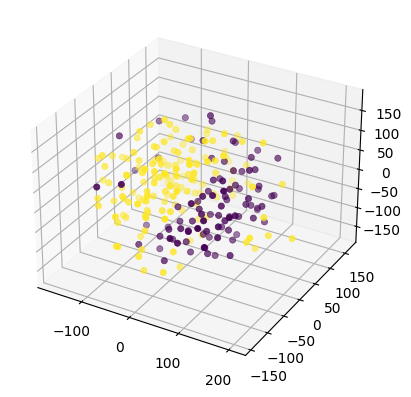

In [37]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(projections[:,0], projections[:,1], projections[:,2],
           c=train_labels, cmap='viridis', linewidth=0.5);

### 2 Dimensions

In [38]:
tsne = TSNE(n_components = 2, random_state=0)
projections = tsne.fit_transform(train_features)

/home/borjaeg/anaconda3/envs/paper_pytorch_transformers/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/borjaeg/anaconda3/envs/paper_pytorch_transformers/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


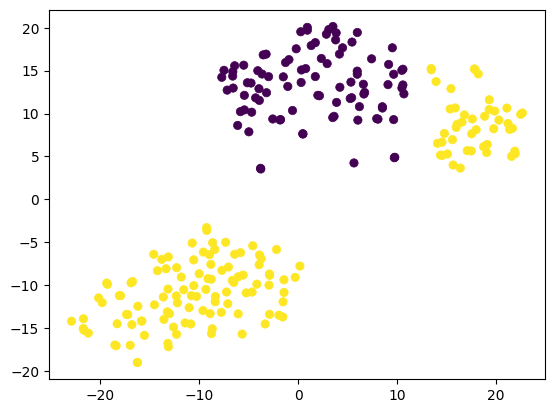

In [39]:
fig = plt.figure()
plt.scatter(projections[:,0], projections[:,1],
            c=train_labels, cmap='viridis', linewidth=0.5);
plt.show()

### Original Image Representation

In [42]:
x_train_flattened = x_train.permute(0, 2, 3, 1).reshape(x_train.shape[0],
                                              x_train.shape[1] * x_train.shape[2] * x_train.shape[3])

### 3 Dimensions

In [46]:
tsne = TSNE(n_components = 3, random_state=0)
projections = tsne.fit_transform(x_train_flattened)

/home/borjaeg/anaconda3/envs/paper_pytorch_transformers/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/borjaeg/anaconda3/envs/paper_pytorch_transformers/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


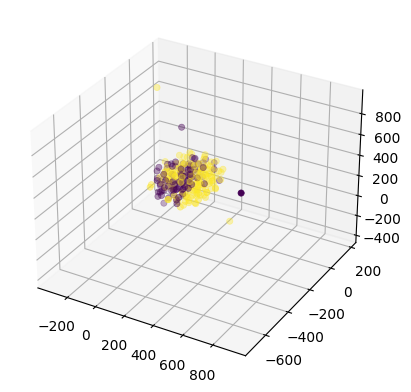

In [47]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(projections[:,0], projections[:,1], projections[:,2],
           c=train_labels, cmap='viridis', linewidth=0.5);

### 2 Dimensions

In [49]:
tsne = TSNE(n_components = 2, random_state=0)
projections = tsne.fit_transform(x_train_flattened)

/home/borjaeg/anaconda3/envs/paper_pytorch_transformers/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/borjaeg/anaconda3/envs/paper_pytorch_transformers/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


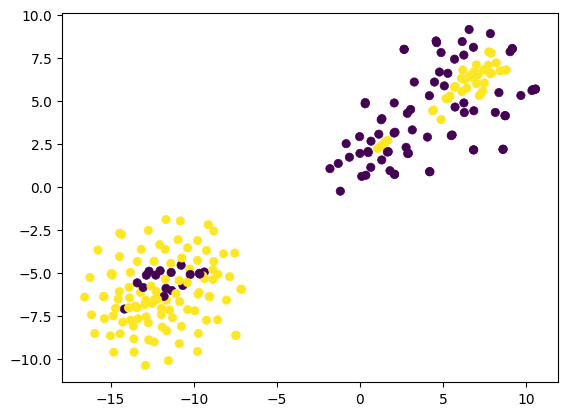

In [50]:
fig = plt.figure()
plt.scatter(projections[:,0], projections[:,1],
            c=train_labels, cmap='viridis', linewidth=0.5);
plt.show()

## Conclusions
The use of CLIP and related models for feature extraction should be explored to boost performances on downstream tasks such as image classification or object detection.

## Possible Extensions
1. Try different ML algorithms on the top of the extracted features by CLIP.
2. Try UMAP to reduce the CLIP representation dimensionality and visualize the results.

## Bibliography
https://openai.com/research/clip